# CAP 6615 Neural Networks Programming Assignment 2 – Multi-Layer Neural Network

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [1]:
# import packages
from PIL import Image
import numpy as np
import itertools
import cv2
from matplotlib import pyplot as plt
import random 
from matplotlib.lines import Line2D
import pandas as pd
import string
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step 1 - Design and build a dataset $𝑋$ of for character recognition of 64 16x16-pixel images (256 pixels per image) from the following online exemplars.

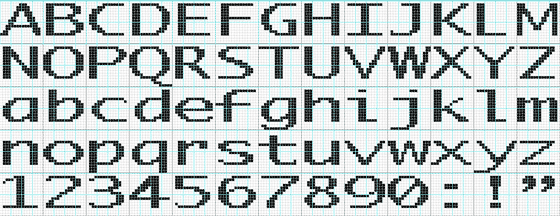

In [3]:
# you can download this 'alphabet.gif' directly from the programming assignment page on Canvas.
im = Image.open('alphabet.gif')
im

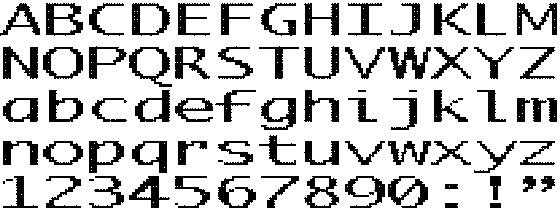

In [4]:
# convert image to black and white
im = im.convert('1')
im

In [5]:
w, h = im.size
print('width: ', w)
print('height:', h)

width:  560
height: 216


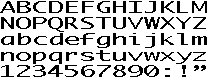

In [6]:
#resize the image
image_height = 16
image_width = 16
m = 13
n = 5
image_size = image_height*image_width
im_resize = im.resize((m*image_width, n*image_height))
im_resize

In [7]:
#check the resize image and change data type
pix = np.array(im_resize)
nrow, ncol = pix.shape
print(pix.shape)
print(pix.dtype)
# change the data type from bool to double
pix = pix.astype(np.float32)
print(pix.dtype)

(80, 208)
bool
float32


In [8]:
# construct the training dataset, validation dataset and testing dataset
n_train_sample = 32
n_val_sample = 16
n_test_sample = 32
n_channel  = 1
dataset_train = np.ndarray(shape=(n_train_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_train.shape
dataset_train.dtype
dataset_val = np.ndarray(shape=(n_val_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_val.shape
dataset_val.dtype
dataset_test = np.ndarray(shape=(n_test_sample, n_channel, image_height, image_width), dtype=np.float32)
dataset_test.shape
dataset_test.dtype

dtype('float32')

In [9]:
#create dataset_all
dataset_all = np.ndarray(shape=(65, n_channel, image_height, image_width), dtype=np.float32)
dataset_all.shape
dataset_all.dtype
idx = 0
for i in range(5):
    for j in range(13):
        x = pix[(i*image_height):( (i+1)*image_height), (j*image_width):( (j+1)*image_width)]
        dataset_all[idx] = x
        idx += 1
print("All images to array!")

All images to array!


In [10]:
lowercase = list(string.ascii_lowercase)
uppercase = list(string.ascii_uppercase)
keys_full = np.array(uppercase + lowercase + list(range(1, 10)) + ['0', ':', '!', '"'])
keys_full
##A-Z is from 1 to 26
##a-z is from 27 to 52
##1 to 9 to 0 is from 53-62
## : is 63, ! is 64, " is 65  

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ':', '!', '"'],
      dtype='<U1')

In [11]:
# flatten the data
dataset_all_reshaped = dataset_all.reshape((65, 1, -1))

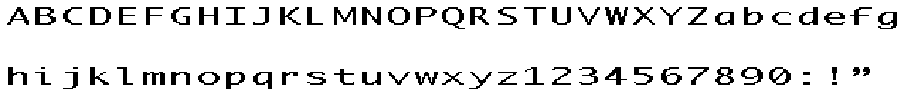

In [12]:
#print all
fig, axs = plt.subplots(2, 33 ,figsize=(16,2))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_all):
        ax.imshow(dataset_all[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

### manually select the training, validation and test dataset

In [13]:
# select training dataset based on dissimilarity
kmeans = KMeans(n_clusters=32, random_state=0).fit(dataset_all_reshaped.reshape(65,-1))
kmeans_labels = kmeans.labels_
kmeans_labels

array([20,  2, 10,  2, 25, 25, 10,  3, 26,  8, 21,  7, 18,  3, 22,  7, 22,
       21,  6, 26,  3, 29, 23, 19, 26, 30, 11, 17, 17,  0, 16, 14, 11,  4,
        9, 24, 21,  9, 15,  4, 16,  4, 11, 17, 16,  9,  4,  5, 13, 28, 27,
       28, 26,  8, 31, 24,  6, 10, 30, 31, 22, 22,  1,  1, 12],
      dtype=int32)

In [14]:
labels_all = list(range(65))
keys_train = np.array([0]*n_train_sample)
labels_train = np.array([0]*n_train_sample)
for i in range(32):
    labels_train[i] = np.where(kmeans_labels == i)[0][0]
labels_train = sorted(labels_train)
labels_test = np.array(list(set(labels_all)^set(labels_train))[0:n_test_sample])
labels_test = sorted(labels_test)
keys_train =  keys_full[labels_train]
print(keys_train)
keys_test =  keys_full[labels_test]
print(keys_test)

#start from 1 to 65
labels_all = [x + 1 for x in labels_all]
labels_train = [x + 1 for x in labels_train]
labels_test = [x + 1 for x in labels_test]
# print(labels_all)
print(labels_train)
print(labels_test)              

['A' 'B' 'C' 'E' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'S' 'V' 'W' 'X' 'Z' 'a' 'b'
 'd' 'e' 'f' 'h' 'i' 'j' 'm' 'v' 'w' 'x' 'y' '3' ':' '"']
['D' 'F' 'G' 'N' 'P' 'Q' 'R' 'T' 'U' 'Y' 'c' 'g' 'k' 'l' 'n' 'o' 'p' 'q'
 'r' 's' 't' 'u' 'z' '1' '2' '4' '5' '6' '7' '8' '9' '0']
[1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 15, 19, 22, 23, 24, 26, 27, 28, 30, 31, 32, 34, 35, 36, 39, 48, 49, 50, 51, 55, 63, 65]
[4, 6, 7, 14, 16, 17, 18, 20, 21, 25, 29, 33, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62]


In [15]:
#create train
for idx in range(n_train_sample):
    dataset_train[idx] = dataset_all[labels_train[idx]-1]

#create test
for idx in range(n_test_sample):
    dataset_test[idx] = dataset_all[labels_test[idx]-1]

    
# flatten the data
dataset_train_reshaped = dataset_train.reshape((n_train_sample, 1, -1))
dataset_test_reshaped = dataset_test.reshape((n_test_sample, 1, -1))

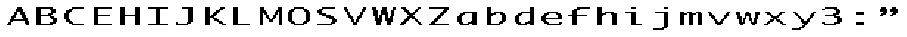

In [16]:
#print train
fig, axs = plt.subplots(1, 32 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_train):
        ax.imshow(dataset_train[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

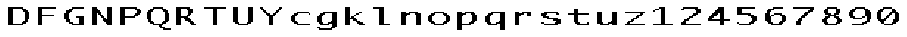

In [17]:
#print test
fig, axs = plt.subplots(1, 32 ,figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_test):
        ax.imshow(dataset_test[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [18]:
# select training dataset based on dissimilarity
kmeans = KMeans(n_clusters=16, random_state=0).fit(dataset_train_reshaped.reshape(32, -1))
kmeans_labels = kmeans.labels_
kmeans_labels

array([14,  9,  7,  7,  9, 11,  4,  1,  1,  3, 15,  4,  2,  5, 10, 11,  8,
        8,  8,  8,  7,  9,  6,  0, 12,  2,  5, 13,  2,  4,  6,  6],
      dtype=int32)

In [19]:
keys_val = np.array([0]*n_val_sample)
keys_train_small = np.array([0]*n_val_sample)
labels_train_small = np.array([0]*n_val_sample)
for i in range(n_val_sample):
    labels_train_small[i] = np.where(kmeans_labels == i)[0][0]
labels_train_small = sorted(labels_train_small)
keys_train_small =  keys_train[labels_train_small]
print(keys_train_small)
labels_val = np.array(list(set(range(32))^set(labels_train_small))[0:n_val_sample])
labels_val = sorted(labels_val)
keys_val =  keys_train[labels_val]
print(keys_val)



# #start from 1 to 65
labels_train_small = np.array([np.where(keys_full == i)[0][0] for i in keys_train_small])
labels_val = np.array([np.where(keys_full == i)[0][0] for i in keys_val])
labels_train_small = [x + 1 for x in labels_train_small]
labels_val = [x + 1 for x in labels_val]
print(labels_train_small)
print(labels_val)   

['A' 'B' 'C' 'I' 'J' 'K' 'M' 'O' 'V' 'W' 'X' 'a' 'i' 'j' 'm' 'x']
['E' 'H' 'L' 'S' 'Z' 'b' 'd' 'e' 'f' 'h' 'v' 'w' 'y' '3' ':' '"']
[1, 2, 3, 9, 10, 11, 13, 15, 22, 23, 24, 27, 35, 36, 39, 50]
[5, 8, 12, 19, 26, 28, 30, 31, 32, 34, 48, 49, 51, 55, 63, 65]


In [20]:
#create val
for idx in range(n_val_sample):
    dataset_val[idx] = dataset_all[labels_val[idx]-1]

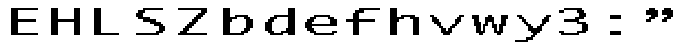

In [21]:
#print val
fig, axs = plt.subplots(1, 16 ,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_val):
        ax.imshow(dataset_val[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()
dataset_val_reshaped = dataset_val.reshape((n_val_sample, 1, -1))

In [22]:
dataset_all_reshaped.shape

(65, 1, 256)

###  Use SIFT (Scale Invariant Feature Transformation) to derive numerical descriptive parameters from the individual data set exemplars

In [23]:
des_train = np.ndarray(shape=(n_train_sample, n_channel, image_height, image_width), dtype=np.float32)
des_train.shape
des_train.dtype
des_val = np.ndarray(shape=(n_val_sample, n_channel, image_height, image_width), dtype=np.float32)
des_val.shape
des_val.dtype
des_test = np.ndarray(shape=(n_test_sample, n_channel, image_height, image_width), dtype=np.float32)
des_test.shape
des_test.dtype

dtype('float32')

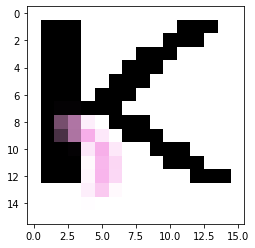

In [24]:
idx = 7
img1 = dataset_train[idx, 0]
img1 = 255 * img1 # Now scale by 255
img = img1.astype(np.uint8)
#find keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create(nfeatures=3)
kp_1, des_1 = sift.detectAndCompute(img,None)
img_1 = cv2.drawKeypoints(img, kp_1,img)
plt.imshow(img_1)

In [25]:
for idx in range(n_train_sample):
    img1 = dataset_train[idx, 0]
    img1 = 255 * img1 # Now scale by 255
    img = img1.astype(np.uint8)
    #find keypoints and descriptors
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=3)
    kp_1, des_1 = sift.detectAndCompute(img,None)
    print(des_1 is None)
#     print(des_1.shape)

    

False
False
False
False
False
True
False
False
False
True
False
False
True
False
True
False
True
False
False
False
False
False
False
False
False
False
False
True
True
False
True
False


## Step 2 - Design and develop two (MLNN) in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 

### Approach 1-a: Simple Network with Scalar Output (use original image as input)

In [26]:
##Approach 1, Adding an extra hidden layer between input layer and output layer
class TrainableEltwiseLayer(nn.Module):
    def __init__(self,D_in):
        super(TrainableEltwiseLayer, self).__init__()
        self.weights = nn.Parameter(torch.randn(D_in))  # define the trainable parameter
        self.linear = nn.Linear(D_in,D_in)
        #self.Sigmoid = nn.Sigmoid()
        self.Relu = torch.nn.ReLU()
    def forward(self, x):
        x_1 = self.linear(x)
        #x_2 = self.Sigmoid(x_1)
        x_2 = self.Relu(x_1)
        # assuming x is of size b-1-h-w
        return torch.sum(x_2 * self.weights) + 1

In [27]:
model_Ap1 = TrainableEltwiseLayer(256)
model_Ap1

TrainableEltwiseLayer(
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (Relu): ReLU()
)

### Approach 2: Fully-connected Network with Image Output:  

In [28]:
model_Ap2 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model_Ap2

Sequential(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): Sigmoid()
)

### Approach 1-b: Simple Network with Scalar Output: (use SIFT metrics as input)

In [29]:
model_Ap1b = TrainableEltwiseLayer(256)
model_Ap1b

TrainableEltwiseLayer(
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (Relu): ReLU()
)

## Step 3 - Train your MLNNs on your Training Set (from Step 1, above) then test each MLNN to ensure it functions correctly before you go on to Step 4.

In [30]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
model_Ap1 = TrainableEltwiseLayer(256)
model_Ap1
# define loss function.
loss_fn = nn.MSELoss()
# Use the optim package to define an Optimizer that will update the weights of the model for us. 
learning_rate = 1e-5
optimizer = optim.Adam(model_Ap1.parameters(), lr=learning_rate)
loss_all_1 = []
for t in range (1000):
    for i, data in enumerate(dataset_train_reshaped):
        y = torch.from_numpy(np.array(labels_train[i])).float()
        x = torch.from_numpy(data).float()
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model_Ap1(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        if (i % 32 == 31 ) and (t % 10 == 0 ):
            print("Epoch {} - loss: {}".format(t, loss.item()))
        if (i % 32 == 31 ):
            loss_all_1 += [loss]

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

Epoch 0 - loss: 3118.330078125
Epoch 10 - loss: 1124.5931396484375
Epoch 20 - loss: 986.0794067382812
Epoch 30 - loss: 922.2476196289062
Epoch 40 - loss: 874.14599609375
Epoch 50 - loss: 829.1422729492188
Epoch 60 - loss: 782.3751831054688
Epoch 70 - loss: 731.462646484375
Epoch 80 - loss: 686.0753173828125
Epoch 90 - loss: 645.204833984375
Epoch 100 - loss: 600.78955078125
Epoch 110 - loss: 554.8442993164062
Epoch 120 - loss: 513.226318359375
Epoch 130 - loss: 473.3038024902344
Epoch 140 - loss: 433.0482177734375
Epoch 150 - loss: 396.11529541015625
Epoch 160 - loss: 360.69854736328125
Epoch 170 - loss: 326.2218017578125
Epoch 180 - loss: 292.0377197265625
Epoch 190 - loss: 261.80511474609375
Epoch 200 - loss: 235.14791870117188
Epoch 210 - loss: 209.42884826660156
Epoch 220 - loss: 186.6372833251953
Epoch 230 - loss: 164.201904296875
Epoch 240 - loss: 143.9185333251953
Epoch 250 - loss: 125.49026489257812
Epoch 260 - loss: 109.11355590820312
Epoch 270 - loss: 94.37411499023438
Epoch 

Text(0, 0.5, 'MSEloss')

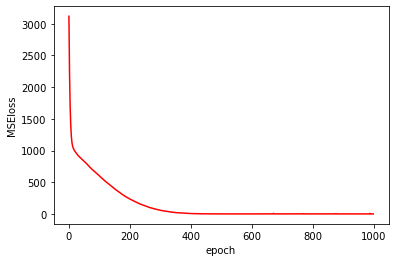

In [31]:
plt.plot(np.array(loss_all_1), 'r')
plt.xlabel("epoch")
plt.ylabel("MSEloss")

In [32]:
# training result in approach 1
cor = 0
for i, data in enumerate(dataset_train_reshaped):
    x = torch.from_numpy(data)
    label = labels_train[i]
    out =round(model_Ap1(x).float().item())
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    if out == label:
        cor += 1 
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/n_train_sample))

answer: 1,output 1
answer: 2,output 2
answer: 3,output 3
answer: 5,output 5
answer: 8,output 8
answer: 9,output 9
answer: 10,output 10
answer: 11,output 11
answer: 12,output 12
answer: 13,output 13
answer: 15,output 15
answer: 19,output 19
answer: 22,output 22
answer: 23,output 23
answer: 24,output 24
answer: 26,output 26
answer: 27,output 27
answer: 28,output 28
answer: 30,output 30
answer: 31,output 31
answer: 32,output 32
answer: 34,output 34
answer: 35,output 35
answer: 36,output 36
answer: 39,output 39
answer: 48,output 48
answer: 49,output 49
answer: 50,output 50
answer: 51,output 51
answer: 55,output 55
answer: 63,output 63
answer: 65,output 65
accuracy:1.0


Epoch 0 - loss: 0.16138529777526855
Epoch 10 - loss: 0.08482570946216583
Epoch 20 - loss: 0.03244178369641304
Epoch 30 - loss: 0.012631772086024284
Epoch 40 - loss: 0.007272698916494846
Epoch 50 - loss: 0.005560353398323059
Epoch 60 - loss: 0.00487168226391077
Epoch 70 - loss: 0.004522331058979034
Epoch 80 - loss: 0.004332435317337513
Epoch 90 - loss: 0.004208114929497242
Epoch 100 - loss: 0.00412704236805439
Epoch 110 - loss: 0.0040725721046328545
Epoch 120 - loss: 0.004033354111015797
Epoch 130 - loss: 0.004004582762718201
Epoch 140 - loss: 0.003983685746788979
Epoch 150 - loss: 0.003967823460698128
Epoch 160 - loss: 0.003955467138439417
Epoch 170 - loss: 0.003945930395275354
Epoch 180 - loss: 0.003938436042517424
Epoch 190 - loss: 0.003932511433959007
Epoch 200 - loss: 0.003927670884877443
Epoch 210 - loss: 0.003923841752111912
Epoch 220 - loss: 0.003920708317309618
Epoch 230 - loss: 0.003918189089745283
Epoch 240 - loss: 0.003916140180081129
Epoch 250 - loss: 0.013330995105206966
E

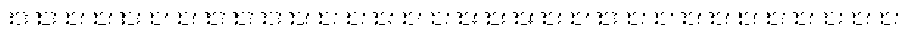

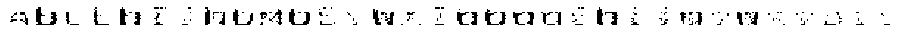

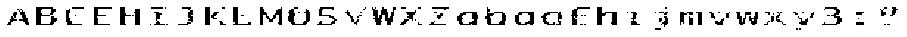

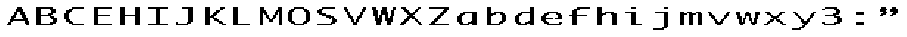

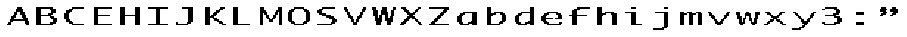

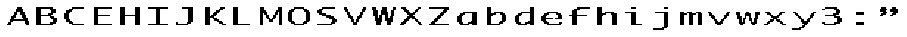

In [33]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
model_Ap2 = torch.nn.Sequential(
    nn.Linear(256, 256),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.Sigmoid()
)
model_Ap2
# define loss function.
loss_fn = nn.MSELoss()
# Use the optim package to define an Optimizer that will update the weights of the model for us. 
learning_rate = 1e-3
optimizer = optim.Adam(model_Ap2.parameters(), lr=learning_rate)
loss_all_2 = []
for t in range (300):
    for i, data in enumerate(dataset_train_reshaped):
        y = torch.from_numpy(data)
        x = torch.from_numpy(data)
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model_Ap2(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)      
        if (i % 32 == 31 ) and (t % 10 == 0 ):
            print("Epoch {} - loss: {}".format(t, loss.item()))
            
        if (i % 32 == 0 ):
            loss_all_2 += [loss]

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        if (i % 32 == 31 ) and (t in [ 0, 4, 9, 49, 99 ,199] ):
            fig, axs = plt.subplots(1, n_train_sample ,figsize=(16, 16))
            for j, data_j in enumerate(dataset_train_reshaped):
                x = torch.from_numpy(data_j)
                output = model_Ap2(x)
                output[output > 0.5] = 1
                output[output <= 0.5] = 0
                pred = output.detach().numpy()
                pred = pred.reshape((image_height, image_width ))
                ax = axs.flatten()[j]
                ax.imshow(pred, cmap='gray', interpolation='nearest')
                ax.axis('off')

Text(0, 0.5, 'MSEloss')

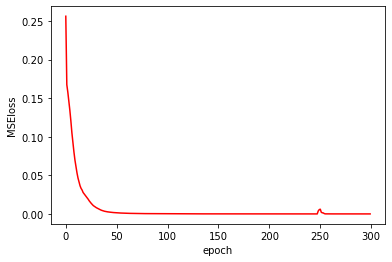

In [34]:
plt.plot(np.array(loss_all_2), 'r')
plt.xlabel("epoch")
plt.ylabel("MSEloss")

### Here, we consider using the validation set to eliminate the overfitting issue for the model 2

## Step 4 - Test your MLNN on the Test Set developed in 1), above -- with no noise introduced into the input dataset. 

answer: 4,output 7
answer: 6,output 18
answer: 7,output 1
answer: 14,output 7
answer: 16,output 9
answer: 17,output 16
answer: 18,output 6
answer: 20,output 21
answer: 21,output 9
answer: 25,output 39
answer: 29,output 39
answer: 33,output 30
answer: 37,output 17
answer: 38,output 37
answer: 40,output 36
answer: 41,output 39
answer: 42,output 31
answer: 43,output 29
answer: 44,output 39
answer: 45,output 39
answer: 46,output 58
answer: 47,output 19
answer: 52,output 35
answer: 53,output 18
answer: 54,output 20
answer: 56,output 24
answer: 57,output 30
answer: 58,output 9
answer: 59,output 41
answer: 60,output 12
answer: 61,output 23
answer: 62,output 21
accuracy:0.0


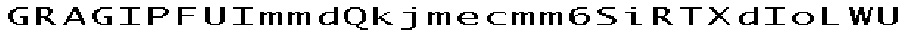

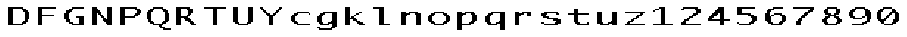

In [35]:
# test approach 1
cor = 0
fig, axs = plt.subplots(1, n_test_sample, figsize=(16,16))
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    label = labels_test[i]
    out =round(model_Ap1(x).float().item())
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    if out == label:
        cor += 1 
    pred = dataset_all[out-1, 0]
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    print("answer: {},output {}".format(label, out))
print("accuracy:{}".format(cor/n_test_sample))


#print test
fig, axs = plt.subplots(1, n_test_sample, figsize=(16,16))
for i, ax in enumerate(axs.flatten()):
    if i < len(dataset_test):
        ax.imshow(dataset_test[i, 0], cmap='gray', interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
    else:
        ax.remove()
plt.show()

In [36]:
#Compute metrics 
def metrics(target, pred):
    Fh = sum((target == 0) & (target == pred))/ sum(target == 0)
    Ffa = sum((target == 1) & (target != pred))/ sum(target == 1)
    return Fh, Ffa

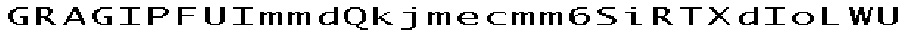

In [37]:
# model 1
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_test_sample ,figsize=(16, 16))
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    label = labels_test[i]
    out =round(model_Ap1(x).float().item())
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    pred = dataset_all[out-1, 0]
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = pred.flatten()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]

Text(0, 0.5, 'Fh')

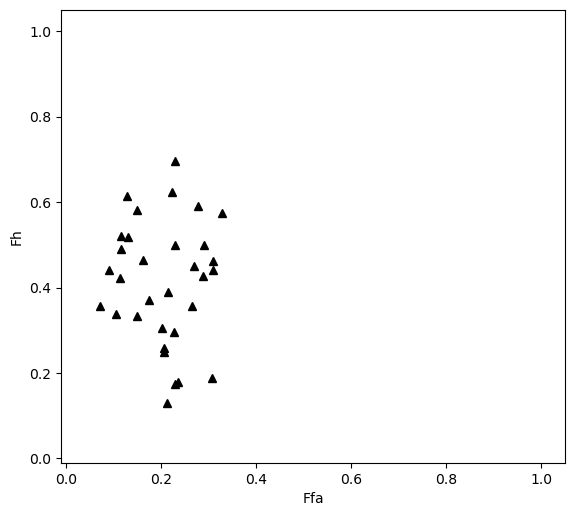

In [38]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")

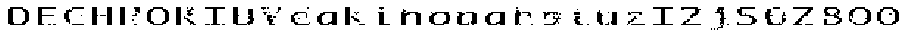

In [39]:
#model 2
Fh_res = []
Ffa_res = []
fig, axs = plt.subplots(1, n_test_sample ,figsize=(16, 16))

for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    output = model_Ap2(x)
    output[output > 0.5] = 1
    output[output <= 0.5] = 0
    pred = output.detach().numpy()
    pred = pred.reshape((image_height, image_width ))
    ax = axs.flatten()[i]
    ax.imshow(pred, cmap='gray', interpolation='nearest')
    ax.axis('off')
    x = x.flatten().detach().numpy()
    y = output.flatten().detach().numpy()
    Fh, Ffa = metrics(x, y)
    Fh_res+= [Fh]
    Ffa_res+= [Ffa]

Text(0, 0.5, 'Fh')

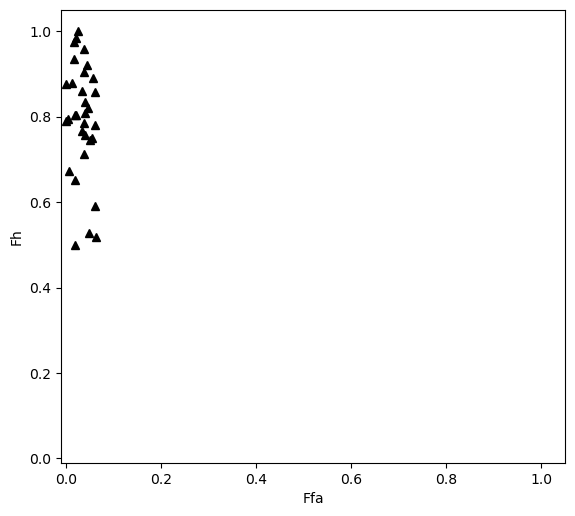

In [40]:
plt.figure(figsize=[6.5,6],dpi=100)
plt.plot(Ffa_res, Fh_res, '^', color='black');
plt.xlim(-0.01, 1.05)
plt.ylim(-0.01, 1.05)
plt.xlabel("Ffa")
plt.ylabel("Fh")
# plt.savefig('Fh_Ffa_noiseless.eps')

## Step 5 - Compute Receiver Operating Characteristic (ROC) from the results of Step 4 (for each MLNN) and graph the result,

In [41]:
# model 1
y_test = np.empty(0, int)
y_score = np.empty(0)
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    label = labels_test[i]
    out =round(model_Ap1(x).float().item())
    if out < 1:
        out = 1
    if out > 65:
        out = 65
    pred = dataset_all[out-1, 0]
    x = x.flatten().detach().numpy()
    y = pred.flatten() 
    y_test = np.append(y_test, x)
    y_score = np.append(y_score, y)

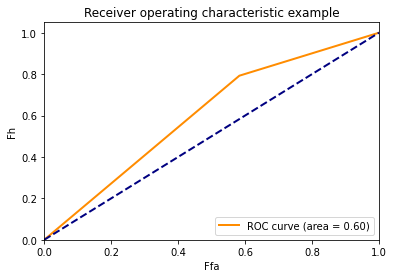

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [43]:
#model 2
y_test = np.empty(0, int)
y_score = np.empty(0)
for i, data in enumerate(dataset_test_reshaped):
    x = torch.from_numpy(data)
    output = model_Ap2(x)
    y = output.flatten().detach().numpy()
    y_score = np.append(y_score, y)
    #output[output > 0.5] = 1
    #output[output <= 0.5] = 0
    x = x.flatten().detach().numpy()   
    y_test = np.append(y_test, x)


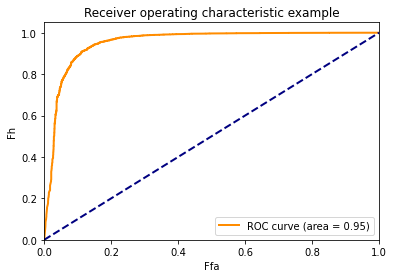

In [44]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


## Step 6 - 6a) Corrupt your Test Set (from 1), above) by adding noise; 

In [45]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 25)
        index = random.sample(list(range(256)), 25)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, 0, index] = dataset_noise[i, 0, index] + s
        dataset_noise[i,0] = NormalizeData(dataset_noise[i,0 ])
    return dataset_noise   

### 6b) Repeat Tests in Step 4), above, with noise-corrupted Test Set and gather the results into a table of Fh and Ffa versus test-image-ID, with one row for each value of the standard deviation

#### model 1

In [46]:
#model 1
Fh_res_all = []
Ffa_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    Fh_res = []
    Ffa_res = []
    fig, axs = plt.subplots(1, n_test_sample ,figsize=(12, 12))
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        label = labels_test[i]
        out =round(model_Ap1(x).float().item())
        if out < 1:
            out = 1
        if out > 65:
            out = 65
        pred = dataset_all[out-1, 0]
        ax = axs.flatten()[i]
        ax.imshow(pred, cmap='gray', interpolation='nearest')
        ax.axis('off')
        x = dataset_test_reshaped[i].reshape([-1])
        y = pred.flatten()
        Fh, Ffa = metrics(x, y)
        Fh_res+= [Fh]
        Ffa_res+= [Ffa]
    Fh_res_all.append(Fh_res)
    Ffa_res_all.append(Ffa_res)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [47]:
Fh_res_all[7]

[0.25316455696202533,
 0.6226415094339622,
 0.703125,
 0.8043478260869565,
 0.25757575757575757,
 1.0,
 0.38461538461538464,
 0.1875,
 0.2191780821917808,
 0.38636363636363635,
 0.38461538461538464,
 0.5802469135802469,
 0.29508196721311475,
 0.7727272727272727,
 0.12903225806451613,
 0.6964285714285714,
 0.5205479452054794,
 0.6301369863013698,
 0.11627906976744186,
 0.4423076923076923,
 0.22,
 0.3709677419354839,
 0.5581395348837209,
 0.45098039215686275,
 0.5,
 0.625,
 0.3559322033898305,
 0.25,
 0.2391304347826087,
 0.5945945945945946,
 0.5753424657534246,
 0.1686746987951807]

Text(0.5, 1.0, 'Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Heteroassociative  Multi-Layer Neural Network')

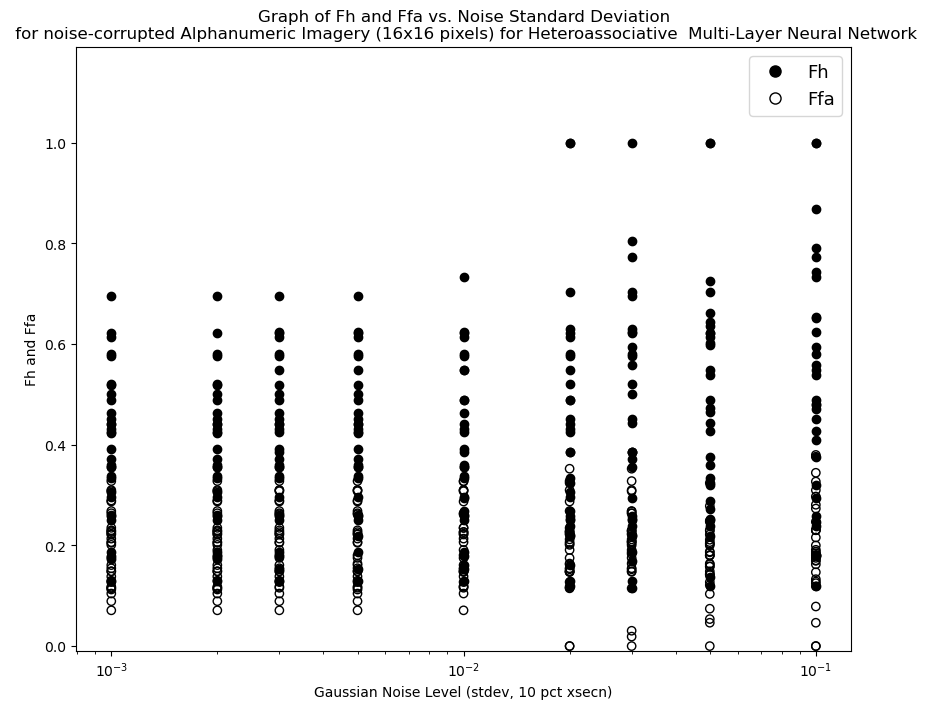

In [48]:
plt.figure(figsize=[10,8],dpi=100)
for i in range(1, len(sd)):
    plt.plot([sd[i]]*n_test_sample, Fh_res_all[i],'o', color='black')
    plt.scatter([sd[i]]*n_test_sample, Ffa_res_all[i], facecolors='none', edgecolors='black')
    plt.xscale('log')

# plt.xlim(0, 0.1)
plt.ylim(-0.01, 1.19)
plt.xlabel("Gaussian Noise Level (stdev, 10 pct xsecn)")
plt.ylabel("Fh and Ffa")
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='k', label='Fh'),
                  Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='w', label='Ffa')]
plt.legend(handles=legend_elements,fontsize=13)
# plt.text(0.002,1.1,'Training set = { \'C\', \'D\', \'E\', \'H\', \'I\', \'1\', \'3\', \'4\', \'5\', \'9\'}',fontsize=13)
plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Heteroassociative  Multi-Layer Neural Network")

# plt.savefig('Fh_Ffa_noise.eps')

In [49]:
##A-Z is from 1 to 26
##a-z is from 27 to 52
##1 to 9 to 0 is from 53-62
## : is 63, ! is 64, " is 65  
labels = keys_full[[x - 1 for x in labels_test]]
Fh_df=pd.DataFrame(Fh_res_all,columns=labels,index=sd).T
Ffa_df=pd.DataFrame(Ffa_res_all,columns=labels,index=sd).T

In [50]:
table=pd.DataFrame()
for i in range(Fh_df.shape[1]):
    table=pd.concat([table,Fh_df.iloc[:,i],Ffa_df.iloc[:,i]],axis=1)
table=table.round(decimals=2)
table

,0.000,0.000,0.001,0.001,0.002,0.002,0.003,0.003,0.005,0.005,0.010,0.010,0.020,0.020,0.030,0.030,0.050,0.050,0.100,0.100
D,0.52,0.13,0.52,0.13,0.52,0.13,0.52,0.13,0.52,0.13,0.73,0.12,0.25,0.20,0.25,0.20,0.25,0.20,0.73,0.12
F,0.62,0.22,0.62,0.22,0.62,0.22,0.62,0.22,0.62,0.22,0.62,0.22,0.62,0.22,0.62,0.22,0.62,0.22,0.47,0.28
G,0.39,0.21,0.39,0.21,0.39,0.21,0.39,0.21,0.39,0.21,0.39,0.21,0.70,0.23,0.70,0.23,0.70,0.23,0.59,0.12
N,0.49,0.12,0.49,0.12,0.49,0.12,0.49,0.12,0.49,0.12,0.49,0.12,0.49,0.12,0.80,0.03,0.60,0.10,1.00,0.00
P,0.26,0.21,0.26,0.21,0.26,0.21,0.26,0.21,0.26,0.21,0.26,0.15,0.26,0.15,0.26,0.15,0.64,0.16,0.77,0.22
Q,0.46,0.16,0.46,0.16,0.46,0.16,0.46,0.16,0.46,0.16,0.46,0.16,1.00,0.00,1.00,0.00,0.43,0.25,0.43,0.25
R,0.42,0.11,0.42,0.11,0.42,0.11,0.38,0.19,0.42,0.11,0.38,0.19,0.38,0.19,0.38,0.19,0.60,0.18,0.74,0.08
T,0.19,0.31,0.19,0.31,0.19,0.31,0.19,0.31,0.19,0.31,0.19,0.31,1.00,0.00,0.19,0.31,1.00,0.00,0.48,0.38
U,0.18,0.23,0.18,0.23,0.18,0.23,0.18,0.23,0.22,0.16,0.18,0.23,0.22,0.16,0.22,0.16,0.22,0.16,0.45,0.27
Y,0.59,0.28,0.43,0.12,0.43,0.12,0.43,0.12,0.43,0.12,0.43,0.12,0.43,0.12,0.39,0.21,0.27,0.28,0.18,0.34


#### model 2

In [51]:
#model 2
Fh_res_all = []
Ffa_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    Fh_res = []
    Ffa_res = []
    fig, axs = plt.subplots(1, n_test_sample ,figsize=(12, 12))
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        output = model_Ap2(x)
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
        pred = output.detach().numpy()
        pred = pred.reshape((image_height, image_width ))
        ax = axs.flatten()[i]
        ax.imshow(pred, cmap='gray', interpolation='nearest')
        ax.axis('off')
        x = dataset_test_reshaped[i].reshape([-1])
        y = output.flatten().detach().numpy()
        Fh, Ffa = metrics(x, y)
        Fh_res+= [Fh]
        Ffa_res+= [Ffa]
    Fh_res_all.append(Fh_res)
    Ffa_res_all.append(Ffa_res)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


Text(0.5, 1.0, 'Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Multi-Layer Neural Network')

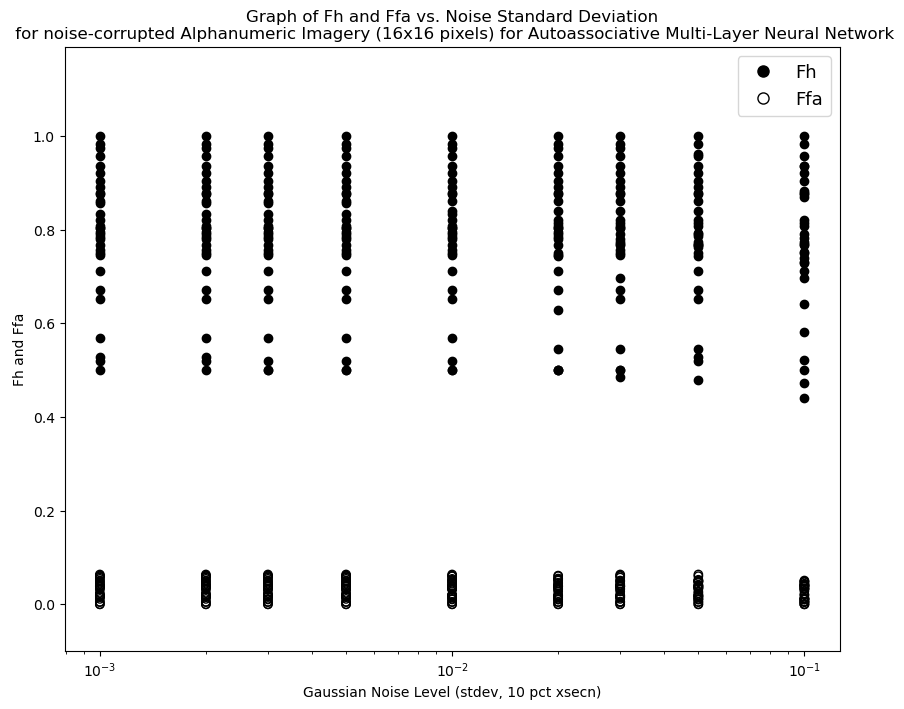

In [52]:
plt.figure(figsize=[10,8],dpi=100)
for i in range(1, len(sd)):
    plt.plot([sd[i]]*n_test_sample, Fh_res_all[i],'o', color='black')
    plt.scatter([sd[i]]*n_test_sample, Ffa_res_all[i], facecolors='none', edgecolors='black')
    plt.xscale('log')

# plt.xlim(0, 0.1)
plt.ylim(-0.1, 1.19)
plt.xlabel("Gaussian Noise Level (stdev, 10 pct xsecn)")
plt.ylabel("Fh and Ffa")
legend_elements = [Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='k', label='Fh'),
                  Line2D([0], [0], marker='o', color='k', lw=0, markersize=8, markerfacecolor='w', label='Ffa')]
plt.legend(handles=legend_elements,fontsize=13)
# plt.text(0.002,1.1,'Training set = { \'C\', \'D\', \'E\', \'H\', \'I\', \'1\', \'3\', \'4\', \'5\', \'9\'}',fontsize=13)
plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation\n for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Multi-Layer Neural Network")

# plt.savefig('Fh_Ffa_noise.eps')

In [53]:
##A-Z is from 1 to 26
##a-z is from 27 to 52
##1 to 9 to 0 is from 53-62
## : is 63, ! is 64, " is 65  
labels = keys_full[[x - 1 for x in labels_test]]
Fh_df=pd.DataFrame(Fh_res_all,columns=labels,index=sd).T
Ffa_df=pd.DataFrame(Ffa_res_all,columns=labels,index=sd).T

In [54]:
table=pd.DataFrame()
for i in range(Fh_df.shape[1]):
    table=pd.concat([table,Fh_df.iloc[:,i],Ffa_df.iloc[:,i]],axis=1)
table=table.round(decimals=2)
table


,0.000,0.000,0.001,0.001,0.002,0.002,0.003,0.003,0.005,0.005,0.010,0.010,0.020,0.020,0.030,0.030,0.050,0.050,0.100,0.100
D,0.97,0.02,0.97,0.02,0.97,0.02,0.97,0.02,0.97,0.02,0.97,0.02,0.97,0.02,0.97,0.02,0.96,0.02,0.94,0.01
F,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02,1.00,0.02
G,0.67,0.01,0.67,0.01,0.67,0.01,0.67,0.01,0.67,0.01,0.67,0.01,0.67,0.01,0.67,0.01,0.67,0.01,0.64,0.01
N,0.80,0.02,0.80,0.02,0.80,0.02,0.80,0.02,0.80,0.02,0.80,0.02,0.80,0.02,0.80,0.02,0.79,0.02,0.78,0.01
P,0.71,0.04,0.71,0.04,0.71,0.04,0.71,0.03,0.71,0.03,0.71,0.03,0.71,0.03,0.70,0.03,0.71,0.04,0.70,0.02
Q,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01,0.88,0.01
R,0.76,0.04,0.76,0.04,0.76,0.04,0.76,0.04,0.76,0.04,0.76,0.04,0.74,0.04,0.76,0.04,0.74,0.03,0.73,0.03
T,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04,0.96,0.04
U,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.04,0.90,0.03
Y,0.59,0.06,0.57,0.06,0.57,0.06,0.57,0.06,0.57,0.06,0.57,0.06,0.55,0.06,0.55,0.06,0.55,0.05,0.52,0.05


### 6c)  Calculate your ROC Curves

In [55]:
cmaps= ['purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue', 'red']

In [56]:
#model 1
y_test_all =[]
y_score_all =[]
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    y_test = np.empty(0, int)
    y_score = np.empty(0)
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        output = model_Ap1(x)
        x = torch.from_numpy(data)
        out =round(model_Ap1(x).float().item())
        if out < 1:
            out = 1
        if out > 65:
            out = 65
        pred = dataset_all[out-1, 0]      
        x = dataset_test_reshaped[i].reshape([-1])
        y = pred.flatten()
        y_score = np.append(y_score, y)
        y_test = np.append(y_test, x)
    y_test_all.append(y_test)
    y_score_all.append(y_score)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


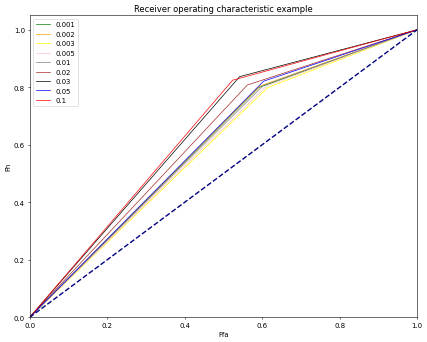

In [57]:
plt.figure(figsize=[10,8],dpi=50)
for i in range(1, len(sd)):
    fpr, tpr, _ = roc_curve(y_test_all[i], y_score_all[i])
    roc_auc = auc(fpr, tpr)
#     print(fpr)
    plt.plot(fpr, tpr, color=cmaps[i], lw=1, label = sd[i])   
    lw = 2
#     
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
plt.legend()
plt.show()


In [58]:
#model 2
y_test_all =[]
y_score_all =[]
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(dataset_test_reshaped, sigma)
    # test results
    y_test = np.empty(0, int)
    y_score = np.empty(0)
    for i, data in enumerate(dataset_test_noise):
        x = torch.from_numpy(data)
        output = model_Ap2(x)
        x = dataset_test_reshaped[i].reshape([-1])
        y = output.flatten().detach().numpy()
        y_score = np.append(y_score, y)
        y_test = np.append(y_test, x)
    y_test_all.append(y_test)
    y_score_all.append(y_score)

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


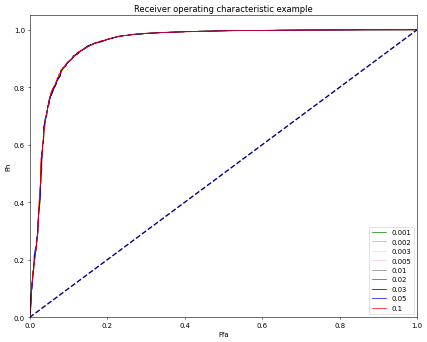

In [59]:
plt.figure(figsize=[10,8],dpi=50)
for i in range(1, len(sd)):
    fpr, tpr, _ = roc_curve(y_test_all[i], y_score_all[i])
    roc_auc = auc(fpr, tpr)
#     print(fpr)
    plt.plot(fpr, tpr, color=cmaps[i], lw=1, label = sd[i])   
    lw = 2
#     
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ffa')
plt.ylabel('Fh')
plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
plt.legend()
plt.show()
